 lfrom # General trace loader
Interface for loading various traces. Tasks include:
- Resolving class imbalance (TODO)
- Noise reduction (TODO)
- General trace format (DOING)

In [2]:
from settings.ascad import ASCADData, ASCADDataType
from collections import Counter
import pandas as pd
import seaborn as sns
sns.set_style("whitegrid")

In [3]:
import numpy as np

class ASCAD:
    def __init__(self):
        self.default = TraceGroup(ASCADData.random_key(), ASCADData.data_range)
        self.random = TraceGroup(ASCADData.random_key(), ASCADData.data_range, True)
        self.desync_50 = TraceGroup(ASCADData.random_key(ASCADDataType.desync_50), ASCADData.data_range)
        self.desync_100 = TraceGroup(ASCADData.random_key(ASCADDataType.desync_50), ASCADData.data_range)

class TraceGroup:
    def __init__(self, trace_group, trace_range, shuffle=False):
        self.profile = TraceCategory(trace_group["Profiling_traces"], trace_range, shuffle)
        self.attack = TraceCategory(trace_group["Attack_traces"], trace_range, shuffle)

class TraceCategory:
    def __init__(self, trace_category, trace_range, shuffle=False):
        self.t_range = trace_range

        self.traces = np.array(trace_category["traces"])
        self.labels = np.array(trace_category["labels"])

        if shuffle:
            np.random.shuffle(self.labels)

        self.tk_cache = {}
        self.ct_cache = {}

    def filter_traces(self, label):
        if label not in self.tk_cache:
            ixs = np.where(np.array(self.labels) == label)[0]
            self.tk_cache[label] = np.array(self.traces[ixs])

        return self.tk_cache[label]

    def contingency_table(self, label):
        """
        Builds a contingency table from traces from the dataset for a given label.

        :param label: the label for which traces the contingency table will be build.
        :return: the contingency table as a numpy array.
        """
        if label not in self.ct_cache:
            df = pd.DataFrame([Counter(bins) for bins in self.filter_traces(label)])
            res = df.sum().sort_index().reindex(self.t_range, fill_value=0).values
            self.ct_cache[label] = np.array(res, dtype=int)

        return self.ct_cache[label]

In [4]:
ascad = ASCAD()
ascad.default.profile.traces.shape

(200000, 1400)

In [5]:
ascad.default.profile.filter_traces(1).shape

(768, 1400)

<AxesSubplot:>

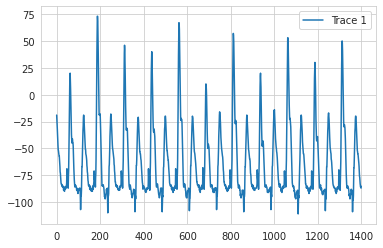

In [6]:
T1 = ascad.default.profile.traces[0]
sns.lineplot(data=pd.DataFrame(T1, columns=["Trace 1"]))

<AxesSubplot:>

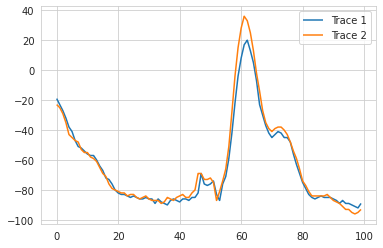

In [7]:
T2 = ascad.default.profile.traces[100]
sns.lineplot(dashes=[(1, 0), (1, 0)], data=pd.DataFrame(list(zip(T1, T2))[:100], columns=["Trace 1", "Trace 2"]))

### Estimated mean of the traces.

In [8]:
ascad.default.profile.traces.mean()

-63.592529775

### Variance of all traces.

In [9]:
ascad.default.profile.traces.var()

1149.782548447886

### Mean and variance between all traces.

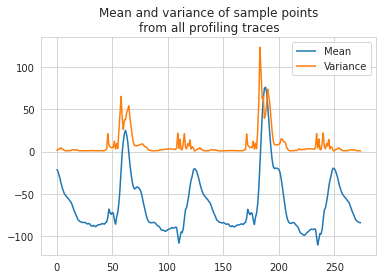

In [10]:
import matplotlib.pyplot as plt

DEFAULT_CUTOFF = 275

def plot_mv_traces(traces, cutoff=DEFAULT_CUTOFF):
    df_mv = pd.DataFrame(list(zip(traces.mean(axis=0), traces.var(axis=0)))[:cutoff], columns=["Mean", "Variance"])

    title = "Mean and variance of sample points\nfrom all profiling traces"
    sns.lineplot(dashes=[(1, 0), (1, 0)], data=df_mv).set_title(title)

def mv_diff(left, right):
    mean_diff = left.mean(axis=0) - right.mean(axis=0)
    var_diff = left.var(axis=0) - right.var(axis=0)

    return mean_diff, var_diff

def plot_mv_diff(left, right, title, cutoff=DEFAULT_CUTOFF):
    cols = ["Mean difference", "Variance difference"]
    df_mv_diff = pd.DataFrame(list(zip(*mv_diff(left, right)))[:cutoff], columns=cols)
    sns.lineplot(data=df_mv_diff[cols[0]])

    ax2 = plt.twinx()
    sns.lineplot(data=df_mv_diff[cols[1]], color=sns.color_palette()[1], ax=ax2).set_title(title)


plot_mv_traces(ascad.default.profile.traces)

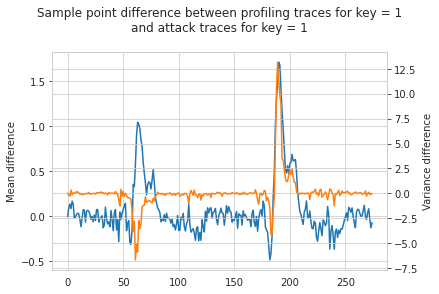

In [11]:
TITLE = "Sample point difference between profiling traces for key = 1\nand attack traces for key = 1\n"
plot_mv_diff(ascad.default.profile.filter_traces(1), ascad.default.attack.filter_traces(1), TITLE)


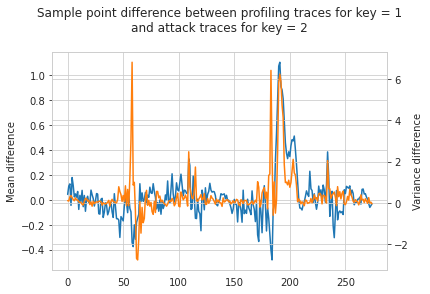

In [12]:
TITLE = "Sample point difference between profiling traces for key = 1\nand attack traces for key = 2\n"
plot_mv_diff(ascad.default.profile.filter_traces(1), ascad.default.attack.filter_traces(2), TITLE)

### Leakage assessment

Sample point averages per key.

First order leakage in first round?

In [13]:
from scipy.stats import skew, kurtosis

def stat_order(a: np.array, order):
    if order == 1:
        return a.mean(axis=0)
    if order == 2:
        return a.var(axis=0)
    if order == 3:
        return skew(a, axis=0)
    if order == 4:
        return kurtosis(a, axis=0)

    Exception(f"Order not implemented: {order}")

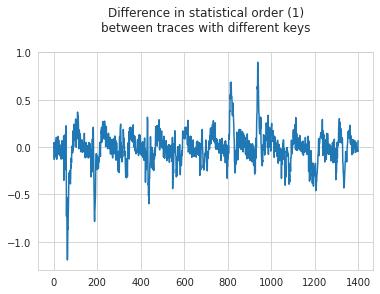

In [35]:
# TODO i am using the attack traces in this test!

def plot_order_difference(db, order):
    key_1 = 1
    key_2 = 2

    # Differences in means with different keys.
    diff_norm_neq = stat_order(db.default.profile.filter_traces(key_1), order) - \
                     stat_order(db.default.attack.filter_traces(key_2), order)

    # Differences in means with equal keys (= noise).
    diff_norm_eq = stat_order(db.default.profile.filter_traces(key_1), order) - \
                    stat_order(db.default.attack.filter_traces(key_1), order)
    # Differences in random means (= noise).
    diff_rand = stat_order(db.random.profile.traces, order) - \
                    stat_order(db.random.attack.traces, order)

    title = f"Difference in statistical order ({order})\nbetween traces with different keys\n"
    sns.lineplot(data=(diff_norm_neq - diff_rand) - (diff_norm_eq - diff_rand)).set_title(title)

plot_order_difference(ascad, 1)

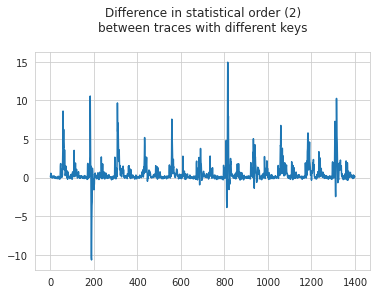

In [15]:
plot_order_difference(ascad, 2)

# Next steps

- Leakage moment detector for statistical moments?

In [39]:
# Under construction
import scipy.stats as stats
stats.moment(ascad.random.profile.traces, 2)

array([0.8033713 , 2.57485519, 2.36217042, ..., 0.86263808, 0.82855498,
       0.84085839])

In [ ]:
# from settings.nbloader import NotebookLoader
# nb = NotebookLoader().load_module("tvla.classic_la")

### $t$ test
The aim of a t-test is to provide a quantitative value as a probability that the mean μ of two sets are different.

For the $t$-test, high $p$ values give reason to reject H0 being "left and right are from different distributions". The traces should be normally distributed for the
    Student's t-test to work.


In [ ]:
# print("exact: ", nb.calc_t([prof_group.contingency_table(1), prof_group.contingency_table(1)]))
# print("same:  ", nb.calc_t([prof_group.contingency_table(1), att_group.contingency_table(1)]))
# print("diff:  ", nb.calc_t([prof_group.contingency_table(1), att_group.contingency_table(2)]))

### $\chi^2$ test

For $\chi^2$, small p-values give reason to reject $H_0$ =
"the occurrences of these observations are independent".
For $t$, large p-values give reason to reject $H_0$ =
"the samples in both sets are drawn from the same population".

In [ ]:
# print("exact: ", nb.calc_chi([prof_group.contingency_table(1), prof_group.contingency_table(1)]))
# print("same:  ", nb.calc_chi([prof_group.contingency_table(1), att_group.contingency_table(1)]))
# print("diff:  ", nb.calc_chi([prof_group.contingency_table(1), att_group.contingency_table(2)]))

# Failed hypotheses

### Correlation between mean and variance for equal / different traces is important

In [ ]:
np.array([np.corrcoef(mv_diff(ascad.default.profile.filter_traces(i),
                              ascad.default.attack.filter_traces(i)))[0][1] for i in range(256)]).mean()

In [ ]:
np.array([np.corrcoef(mv_diff(ascad.default.profile.filter_traces(1),
                              ascad.default.attack.filter_traces(i)))[0][1] for i in range(256)]).mean()

Differences (1st order statistical moment) and variances (2nd order statistical moment)

In [ ]:
def gen_diff(group: TraceGroup, order=1):
    keys = range(256)
    att_all = stat_order(group.attack.traces, order)
    mean_acc_diff = np.zeros(len(keys))

    for key in keys:
        prof_key = stat_order(group.profile.filter_traces(key), order)
        att_key = stat_order(group.attack.filter_traces(key), order)

        mean_acc_diff[key] = abs(prof_key - att_key).mean() - abs(prof_key - att_all).mean()

    return mean_acc_diff

In [ ]:
_ = sns.boxplot(data=pd.DataFrame({
    "Key vs. all": gen_diff(ascad.default),
    "Randomized": gen_diff(ascad.random)
}), showfliers = False).set_title('First order statistical moment')

In [ ]:
_ = sns.boxplot(data=pd.DataFrame({
    "Key vs. all": gen_diff(ascad.default, 2),
    "Randomized": gen_diff(ascad.random, 2)
}), showfliers = False).set_title('Second order statistical moment')